In [31]:
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing
import pandas_datareader.data as web
from pandas import Series, DataFrame
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sb
from fbprophet import Prophet

%matplotlib inline

In [32]:
import os
print(os.getcwd())

/Users/babydonkeyjesus/Online_Classes/Siraj_make_money_machine_learning


In [33]:
# datapath = "../Siraj_make_money_machine_learning/Week_2_finance_stock_predictions/data/btc_usd.csv"
# df = pd.read_csv(datapath)

start = datetime.datetime(2015, 9,6)
end = datetime.datetime(2019, 9, 6)

df = web.DataReader("BTC-USD", 'yahoo', start, end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-05,243.639999,234.740005,233.669998,239.860001,15939620,239.860001
2015-09-06,242.660004,237.490005,239.860001,239.580002,13744695,239.580002
2015-09-07,246.380005,239.229996,239.580002,243.240005,18605471,243.240005
2015-09-08,244.339996,236.490005,243.240005,237.410004,16636258,237.410004
2015-09-09,240.630005,234.309998,237.410004,238.080002,14447606,238.080002


In [34]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-02,10773.269531,10296.299805,10387.500000,10625.099609,550564712,10625.099609
2019-09-03,10827.139648,10392.879883,10625.099609,10585.200195,436210232,10585.200195
2019-09-04,10659.599609,10475.879883,10585.200195,10556.160156,253210793,10556.160156
2019-09-05,10938.389648,10228.169922,10556.160156,10309.910156,577987384,10309.910156
2019-09-06,10574.990234,10304.219727,10309.910156,10491.959961,197436363,10491.959961


In [35]:
# Calculating a 100-day moving average
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

print(mavg.tail(20))

Date
2019-08-18     9823.106167
2019-08-19     9861.037466
2019-08-20     9884.290566
2019-08-21     9905.530371
2019-08-22     9927.796973
2019-08-23     9950.556577
2019-08-24     9978.254478
2019-08-25    10009.242778
2019-08-26    10029.066079
2019-08-27    10046.311479
2019-08-28    10061.760273
2019-08-29    10081.363872
2019-08-30    10098.844272
2019-08-31    10116.563877
2019-09-01    10139.847578
2019-09-02    10158.836270
2019-09-03    10176.836572
2019-09-04    10195.209678
2019-09-05    10211.663184
2019-09-06    10233.820283
Name: Adj Close, dtype: float64


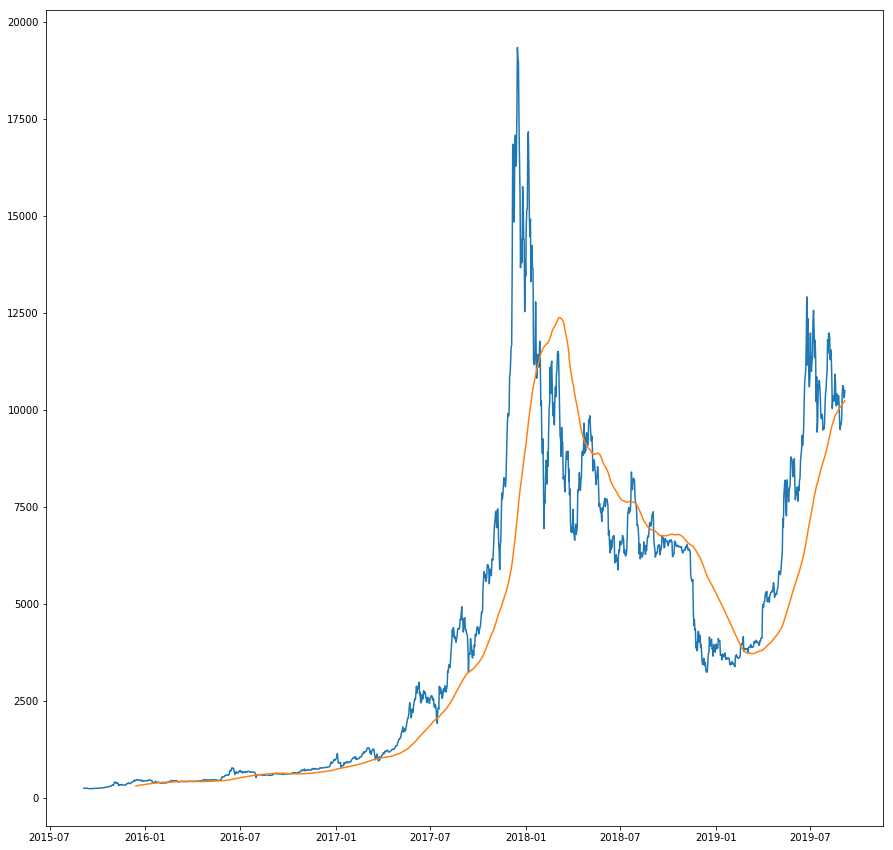

In [58]:
plt.plot(close_px, label="BTC")
plt.plot(mavg, label="mavg")
plt.rc('figure', figsize=(12,12))

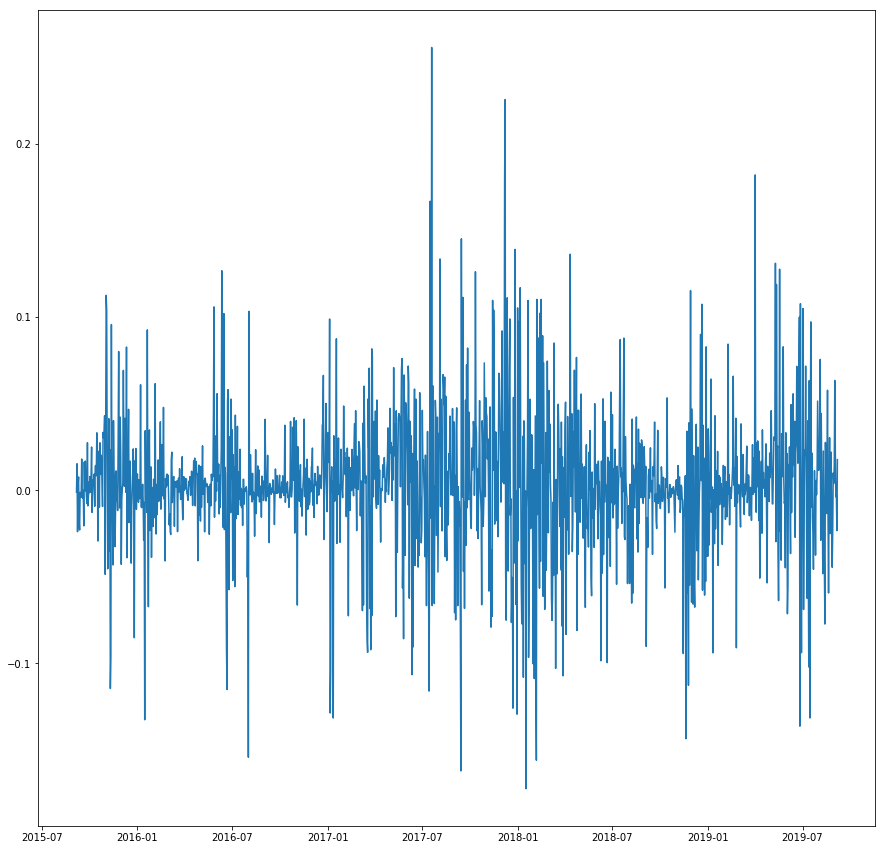

In [37]:
# Return deviation
rets = close_px / close_px.shift(1) - 1
plt.plot(rets, label='return')

In [38]:
dfcomp = web.DataReader(['ETH-USD', 'BTC-USD', 'XRP-USD', 'LTC-USD'],'yahoo',start=start,end=end)['Adj Close']
print(dfcomp.head())

Symbols        BTC-USD  ETH-USD  LTC-USD   XRP-USD
Date                                              
2015-09-05  239.860001    1.340    3.046  0.007590
2015-09-06  239.580002    1.276    3.045  0.007999
2015-09-07  243.240005    1.263    3.029  0.008000
2015-09-08  237.410004    1.210    2.894  0.008500
2015-09-09  238.080002    1.186    2.931  0.007700


In [39]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

print(corr)

Symbols   BTC-USD   ETH-USD   LTC-USD   XRP-USD
Symbols                                        
BTC-USD  1.000000  0.439515  0.576443  0.244115
ETH-USD  0.439515  1.000000  0.412659  0.217395
LTC-USD  0.576443  0.412659  1.000000  0.305285
XRP-USD  0.244115  0.217395  0.305285  1.000000


Text(0, 0.5, 'Returns ETHUSD')

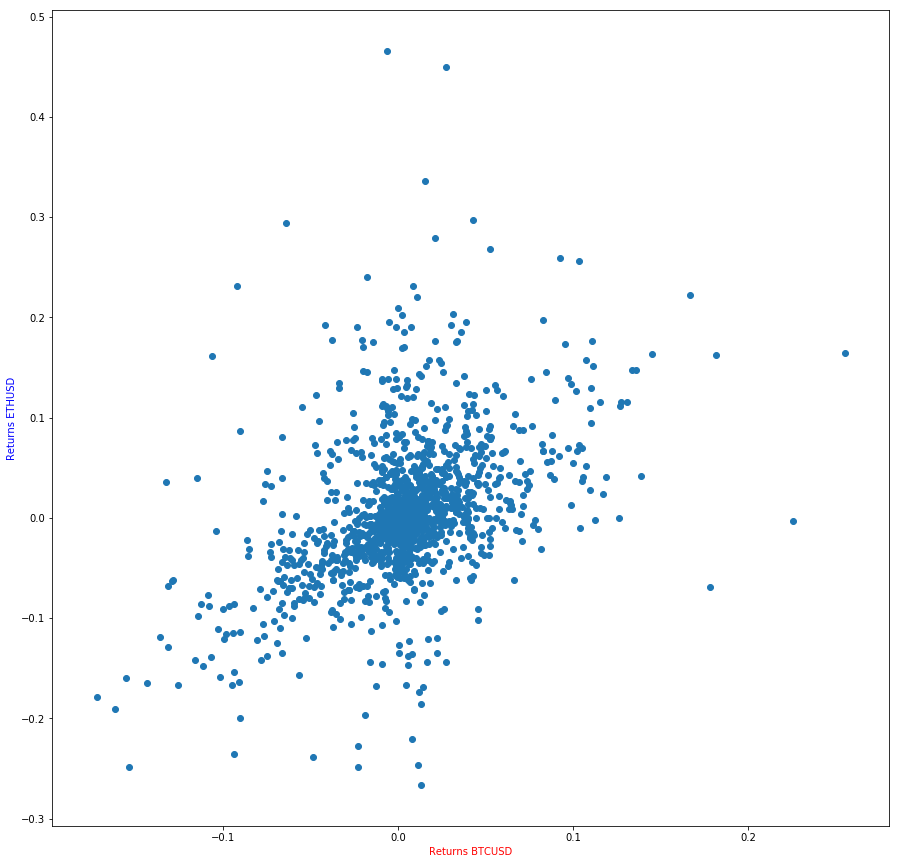

In [40]:
plt.scatter(retscomp['BTC-USD'], retscomp['ETH-USD'])
plt.xlabel('Returns BTCUSD', color='r')
plt.ylabel('Returns ETHUSD', color='b')


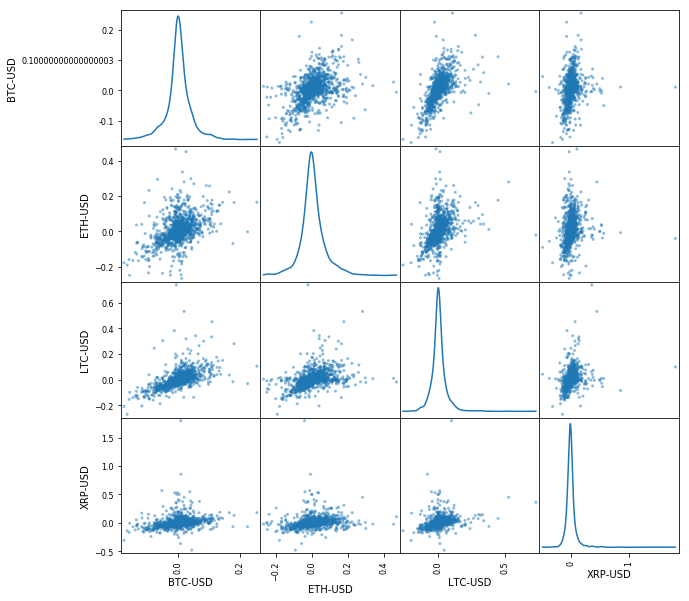

In [41]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

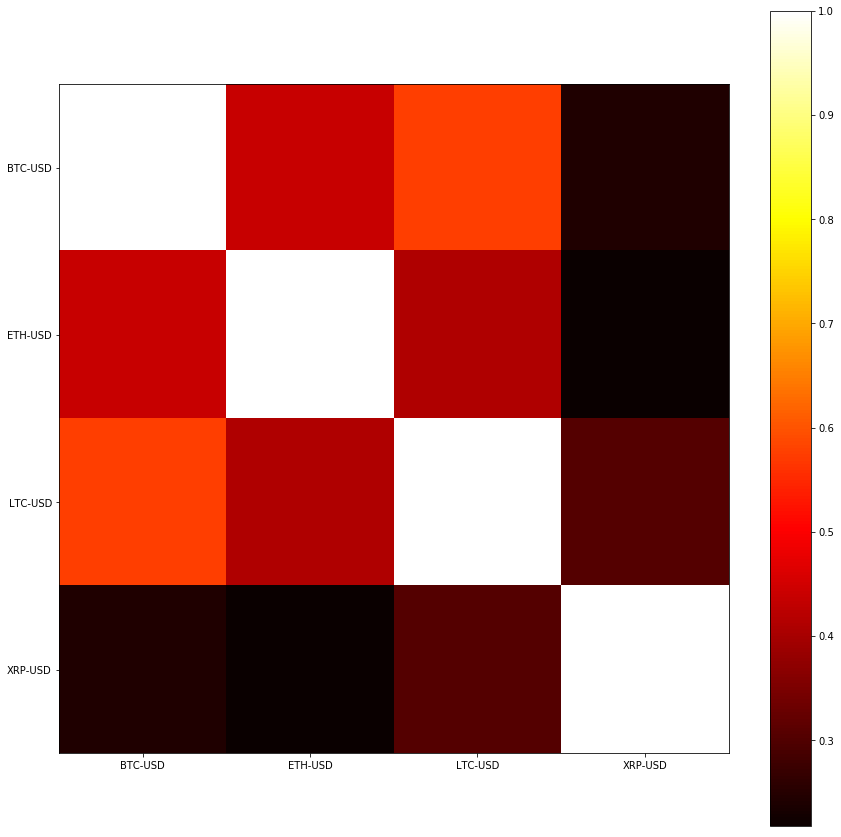

In [42]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

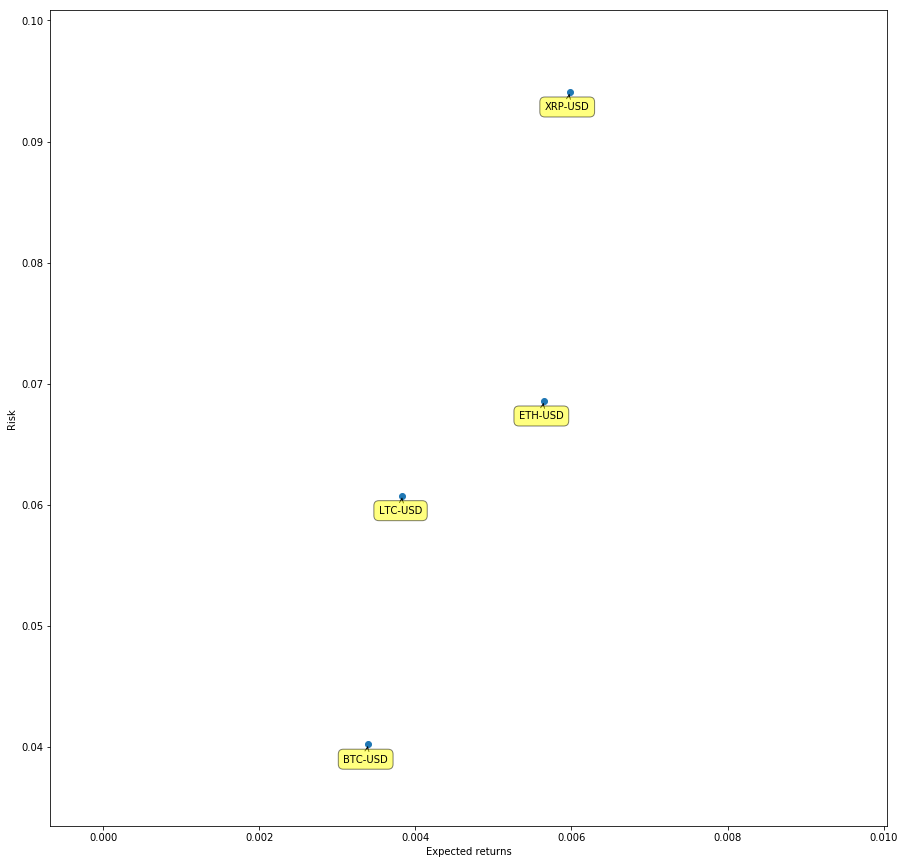

In [43]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [44]:
dfreg = df.loc[:, ['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_Change
Date,,,,
2015-09-05,239.860001,15939620,3.710495,2.649036
2015-09-06,239.580002,13744695,2.157942,-0.116734
2015-09-07,243.240005,18605471,2.939487,1.527675
2015-09-08,237.410004,16636258,3.306512,-2.396810
2015-09-09,238.080002,14447606,2.654573,0.282211


In [45]:
import math
import numpy as np
import sklearn

from sklearn import preprocessing
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [47]:
len(X)

1448

In [48]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [49]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [50]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [51]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [52]:
confidencereg

0.896992944944708

In [53]:
confidencepoly2

0.9129231505207769

In [54]:
confidencepoly3

0.9125857837494566

In [55]:
confidenceknn

0.9008201134901159

In [56]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

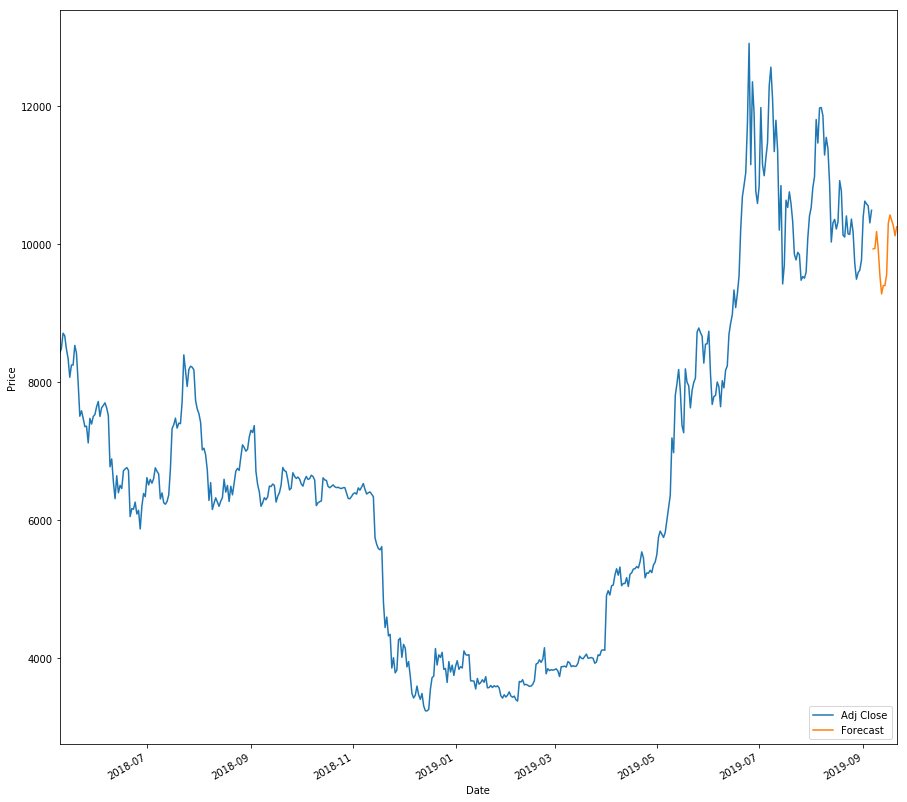

In [57]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()